# **Lab 7: Sequential Networks**
### Authors: Will Lahners, Edward Powers, and Nino Castellano
________________________________________________________________

## **Describing the Data**

We've decided to use a dataset named "Coronavirus tweets NLP - Text Classification" from Kaggle: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/code

The "Coronavirus Tweets NLP" dataset contains a collection of tweets related to the coronavirus (COVID-19) pandemic, which have been curated for natural language processing (NLP) tasks. This dataset encompass a wide range of features including location (where the tweet was tweeted from), tweet at (who the tweet was tweeted to), original tweet (tweet text), and sentiment (labeled as positive, negative, or other) that deal with discussions about the virus. Analyzing this dataset may provide valuable insights into public opinion, trends, and behaviors surrounding the pandemic, making it a valuable resource for understanding the societal impact of COVID-19.


**As mentioned previously, the dataset contains 4 columns of data:**

1-Location | 2-Tweet At | 3-Original Tweet | 4-Sentiment Label

Our focus lies solely on categories 3 and 4. The primary tweet serves as the original text, centered around coronavirus (COVID), while the label constitutes a five-tier categorical assignment indicating the sentiment or overall emotion expressed within the tweet. Our aim is to construct a model capable of accurately forecasting the sentiment of incoming tweets. Thus, when presented with a character string, the classifier will yield a sentiment spanning from Extremely Negative to Extremely Positive. This tool could prove instrumental in gauging public sentiment toward the coronavirus pandemic.

## **Preparation**

> [1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.

In [2]:
# Load the dataset
import pandas as pd
import numpy as np

train = pd.read_csv('./COVID_TweetData/Corona_NLP_train.csv', encoding='latin-1')

train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [3]:
train_data = {
    'text' : train['OriginalTweet'][:].values.tolist(),
    'label': train['Sentiment'][:].values.tolist(),
}

train_df = pd.DataFrame(train_data)
train_df.info()
train_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    41157 non-null  object
 1   label   41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


,text,label
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


Max tweet size: 355


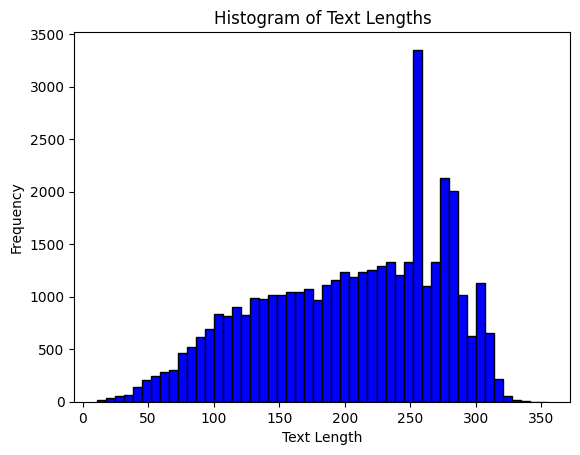

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

text_lengths = [len(text) for text in train_df['text']]
print(f'Max tweet size: {max(text_lengths)}')

# Plotting a histogram
plt.hist(text_lengths, bins=50, color='blue', edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths')
plt.show()

We need all our inputs to be the same size, so to check that we used a histogram to visualize the current distribution of data by length to decide if truncation is necessary. The histogram depicted above indicates that the vast majority of the training dataset falls below the 350-character mark. Upon examination of the maximum length, we ascertain that by setting the cutoff at 355, we encompass 100% of our training data. In our decision-making process, we opted against excluding any rows and instead established the length limit at 355. To maintain uniformity, we employ padding techniques on input sequences, ensuring that shorter tweets are appropriately sized.

In [5]:
train_df['label'].value_counts()

label
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64


As evident, our dataset exhibits class imbalance. Yet, it's expected to observe fewer instances at the extreme ends (i.e., Extreme Positive and Extreme Negative) and a larger concentration around the middle (i.e., Positive, Neutral, and Negative). Consequently, we'll implement stratification in both the training and testing sets to mirror this distribution, aligning with real-world scenarios.

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_df['label'])

print(y_train_encoded)

[3 4 4 ... 4 3 2]


In [7]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 355 # maximum and minimum number of words

# tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(train_df['text'])
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(train_df['text'])

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index), NUM_TOP_WORDS))
print('Train set:')
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index), top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y = keras.utils.to_categorical(y_train_encoded)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)
print(np.max(X))

Train set:
Found 85198 unique tokens. Distilled to 85198 top words.
Shape of data tensor: (41157, 355)
Shape of label tensor: (41157, 5)
85198


In [8]:
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt

# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_train_encoded, random_state=42)

The representation of the data is now:
* Conversion of each word into an integer.
* Construction of each tweet as a sequence of integers, preserving the original word order.
* Utilization of one-hot encoding for target variables.

Tokenization, a key step in this process, involves breaking down the textual data into individual tokens, typically words or subwords. Each unique token is then assigned a unique integer identifier. This conversion facilitates the transformation of text into a format that machine learning algorithms can process effectively. By encoding words as integers and structuring tweets as sequences of these integers, we create a numerical representation of the text data. Finally, employing one-hot encoding for target labels ensures that categorical variables are appropriately represented for training and evaluation.

> [1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.


Our evaluation metric of choice will be accuracy, serving as the primary measure to assess our algorithm's performance. Given that the model's task involves sentiment classification, the consequences of misclassification are not notably severe or imbalanced. Therefore, our criterion for gauging the model's efficacy lies in its capacity to accurately predict the sentiment of the highest proportion of tweets compared to alternative models. Notably, previous classification attempts on this dataset on Kaggle have attained a validation accuracy of 74%. Hence, our objective is to either match or surpass this benchmark with increased efficiency or outright outperform their model on the testing set.

> [1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.


To partition our dataset into training and testing subsets, we'll employ the train_test_split function from the sklearn model selection module. Adopting an 80-20 split ratio, our training set encompasses 32,925 data points, while our testing set comprises 8,232 data points. These sizes are deemed adequate for effectively assessing the performance of our sentiment predictor model. Employing stratified splitting ensures that the proportions of the response variable are maintained across both sets, mirroring the distribution in our dataset accurately. This approach to train-test division is expected to yield a validation accuracy reflective of the model's real-world performance when applied to unseen tweets.

## **Modeling**

> [3 points] Investigate at least two different sequential network architectures (e.g., a CNN and a Transformer). Alternatively, you may also choose a recurrent network and Transformer network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust one hyper-parameter of each network to potentially improve generalization performance (train a total of at least four models). Visualize the performance of training and validation sets versus the training iterations, showing that the models converged.

#### **Using GloVe Embedding from Machine Learning Notebooks-GitHub:**

In [19]:
%%time
# Code adopted from https://github.com/eclarson/MachineLearningNotebooks/blob/master/13a.%20Sequence%20Basics%20%5Bexperimental%5D.ipynb
EMBED_SIZE = 50
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('/Users/SeanPC/Desktop/Glove_Embedding/glove.6B.50d.txt', encoding="utf-8")
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

import warnings
# Ignore UserWarning from Embedding layer
warnings.filterwarnings("ignore", category=UserWarning)
from tensorflow.keras.layers import Embedding

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix], # here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

Found 400000 word vectors.
Embedding Shape: (85199, 50) 
 Total words found: 30397 
 Percentage: 35.67764879869482


ValueError: Unrecognized keyword arguments passed to Embedding: {'weights': [array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.68046999, -0.039263  ,  0.30186   , ..., -0.073297  ,
        -0.064699  , -0.26043999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.35160005,  0.80080003, -0.39409   , ...,  0.43419001,
        -0.37169999, -1.52900004],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])]}

#### **CNN Architecture:**

We'll proceed with the following steps:

* Utilize an embedding layer to convert the input sequence into a dense representation.
* Train 1D filters to convolve with the output obtained from the embedded sequence.

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout

NUM_CLASSES = 5

sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 355
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 355-4=351
x = MaxPooling1D(5)(x) # after max pool, 351/5 = 70
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 66
x = MaxPooling1D(5)(x) # after max pool, size is 66/5 = 13
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 9 elements long
x = MaxPooling1D(9)(x) # this is the size to globally flatten 
# flattened vector max pools across each of the 9 elements
# so vectors is now 128 dimensions (same as num output filters)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['acc'])

print(model.summary())

NameError: name 'embedding_layer' is not defined